N_inf = 1.0, A = 19.29 ± 0.44
N_inf = 1.0, A = 19.74 ± 0.32
N_inf = 1.0, A = 18.19 ± 0.43
N_inf = 1.0, A = 17.05 ± 0.62
N_inf = 1.0, A = 16.06 ± 0.40


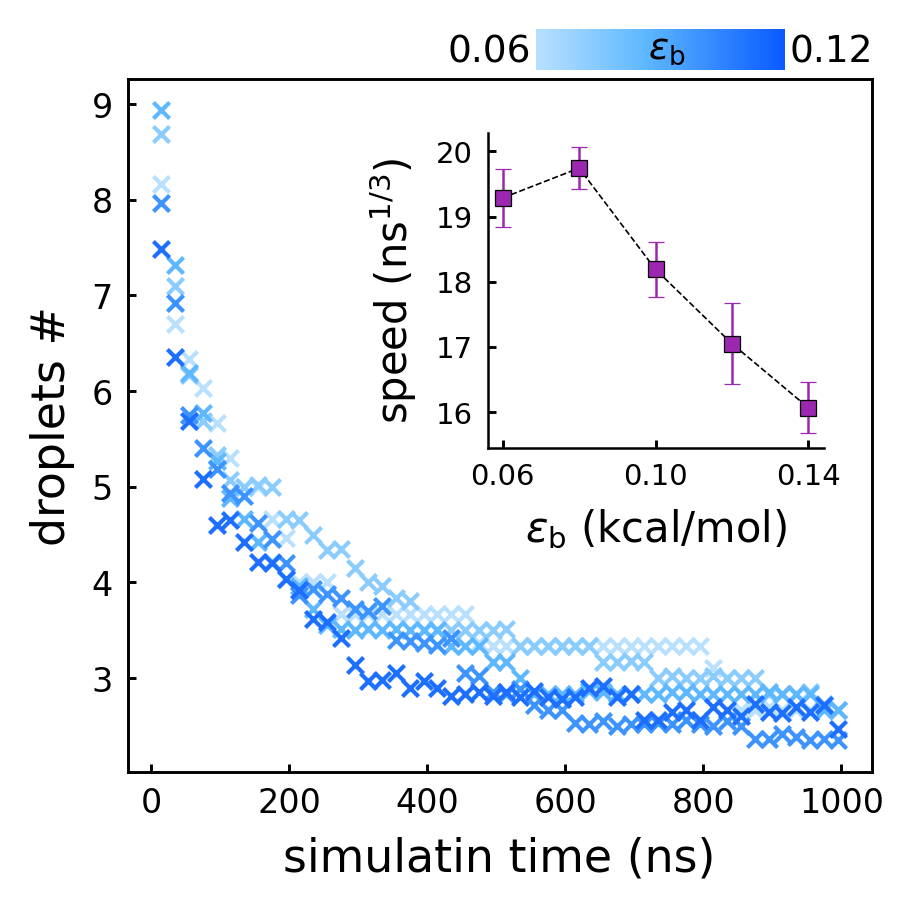

In [ ]:
import sys, os, numpy as np
import MDAnalysis as mda
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
from scipy.ndimage import label
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
from scipy import ndimage
from matplotlib.colors import LinearSegmentedColormap, Normalize

def count_nucleus(rhoz):
    threshold = np.mean(rhoz) - np.std(rhoz)*0
    mask = rhoz > threshold
    labeled, n_cores = label(mask)

    if labeled[0] != 0 and labeled[-1] != 0:
        n_cores -= 1
    
    return n_cores

# def count_nucleus(density):
#     binary = density > 0
#     labeled, num_features = ndimage.label(binary)

#     if binary[0] and binary[-1] and labeled[0] != labeled[-1]:
#         labeled[labeled == labeled[-1]] = labeled[0]
#         num_features -= 1
    
#     return sum(np.sum(labeled == i) >= 5 for i in range(1, num_features + 1))

def num2time(t, N_inf, A):
    return N_inf + A*(t)**(-1/3)

def plot_rho_after_1ns():
    eb_list = [0.06, 0.08, 0.10, 0.12, 0.14]
    clist = cm.Blues(np.arange(0.35, 0.95, 0.59/(1+len(eb_list))))
    cmap_blue = LinearSegmentedColormap.from_list("bright_blue", ["#E0F2FF", "#5EB8FF", "#0050FF"], N=256)
    clist_blue = cmap_blue(np.linspace(0.15, 0.85, len(eb_list)))
    # fig = plt.figure(figsize=(4, 3.5), dpi=100)
    fig, ax = plt.subplots(1, 1, figsize=[3.2, 3.0], facecolor='w', dpi=300)
    fit_list, err_list = [], []
    for eb in eb_list:
        folder = 'des_0.20_{:.2f}_0.02'.format(eb)
        num_list_all = []
        start, nrep = 0, 6
        for irep in range(start, nrep):
            rhoz_path = 'traj_fusion/poly50/{}/rho_data_{}.npy'.format(folder, irep)
            rhoz_all = np.load(rhoz_path)
            time_list, num_list = [], []
            for frame in range(1000, rhoz_all.shape[0]):
                rhoz = rhoz_all[frame]
                time_list.append(10+(frame-1000))
                num_list.append(count_nucleus(rhoz))
            num_list_all.append(num_list)
        
        time_list = np.array(time_list)
        num_avg = np.mean(num_list_all, axis=0)

        smooth_window = 10
        n_windows = len(num_avg) // smooth_window
        avg_density = np.zeros(n_windows)
        var_density = np.zeros(n_windows)
        time_window = np.zeros(n_windows)
        for i in range(n_windows):
            start = i * smooth_window
            end = start + smooth_window
            window_data = num_avg[start:end]
            avg_density[i] = np.mean(window_data)
            var_density[i] = np.var(window_data)
            time_window[i] = np.mean(time_list[start:end])

        upper_bounds = [1.1, np.inf]
        lower_bounds = [1, -np.inf]
        param, pcov = curve_fit(num2time, time_window, avg_density, bounds=(lower_bounds, upper_bounds))
        perr = np.sqrt(np.diag(pcov))
        num_fit = num2time(time_list, *param)

        print('N_inf = {:.1f}, A = {:.2f} ± {:.2f}'.format(param[0], param[1], perr[1]))
        fit_list.append(param[1])
        err_list.append(perr[1])

        plt.scatter(time_window[::2], avg_density[::2], marker='x', s=15, linewidths=1, color=clist_blue[eb_list.index(eb)])
    
    plt.xlabel('simulatin time (ns)', fontsize=11)
    plt.ylabel('droplets #', fontsize=11)
    plt.tick_params(labelsize=8, direction='in', length=2, width=0.7)

    for spine in ax.spines.values():
        spine.set_linewidth(0.7)

    ax_inset = fig.add_axes([0.5, 0.47, 0.35, 0.35])
    ax_inset.errorbar(eb_list, fit_list, err_list, fmt='s', markerfacecolor='#9C27B0', markeredgecolor='k', markersize=4, markeredgewidth=0.3, linestyle='--', linewidth=0.4, color='k', ecolor='#9C27B0', capsize=2, elinewidth=0.6, capthick=0.6, zorder=1000)
    ax_inset.set_xlabel(r'$\epsilon_{\mathregular{b}}$ (kcal/mol)', fontsize=10)
    ax_inset.set_ylabel(r'speed (ns$^{1/3}$)', fontsize=10)
    ax_inset.set_xticks(eb_list[::2])
    ax_inset.tick_params(labelsize=7, direction='in', length=2, width=0.7)
    ax_inset.spines['top'].set_visible(False)
    ax_inset.spines['right'].set_visible(False)
    ax_inset.spines['left'].set_linewidth(0.6)
    ax_inset.spines['bottom'].set_linewidth(0.6)

    cbar_ax = fig.add_axes([0.55, 0.89, 0.26, 0.045])
    cmap_partial = mpl.colors.ListedColormap(cmap_blue(np.linspace(0.15, 0.95, 256)))
    norm = Normalize(vmin=-1, vmax=1)
    sm = mpl.cm.ScalarMappable(cmap=cmap_partial, norm=norm)
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.outline.set_linewidth(0)
    cbar.set_ticks([])
    plt.text(0.7, 1.03, r'$\epsilon_\mathregular{b}$', transform=ax.transAxes, fontsize=9, zorder=10)
    plt.text(0.43, 1.025, '0.06', transform=ax.transAxes, fontsize=9, zorder=10)
    plt.text(0.89, 1.025, '0.12', transform=ax.transAxes, fontsize=9, zorder=10)

    plt.savefig("../../figures/diffusion/nuclei2time_eb.svg", format="svg", bbox_inches='tight')
    plt.show()

plot_rho_after_1ns()

N_inf = 1.9, A = 17.86 ± 0.73
N_inf = 1.0, A = 17.29 ± 0.36
N_inf = 1.0, A = 17.05 ± 0.62
N_inf = 1.0, A = 17.98 ± 0.87
N_inf = 1.0, A = 18.71 ± 0.48


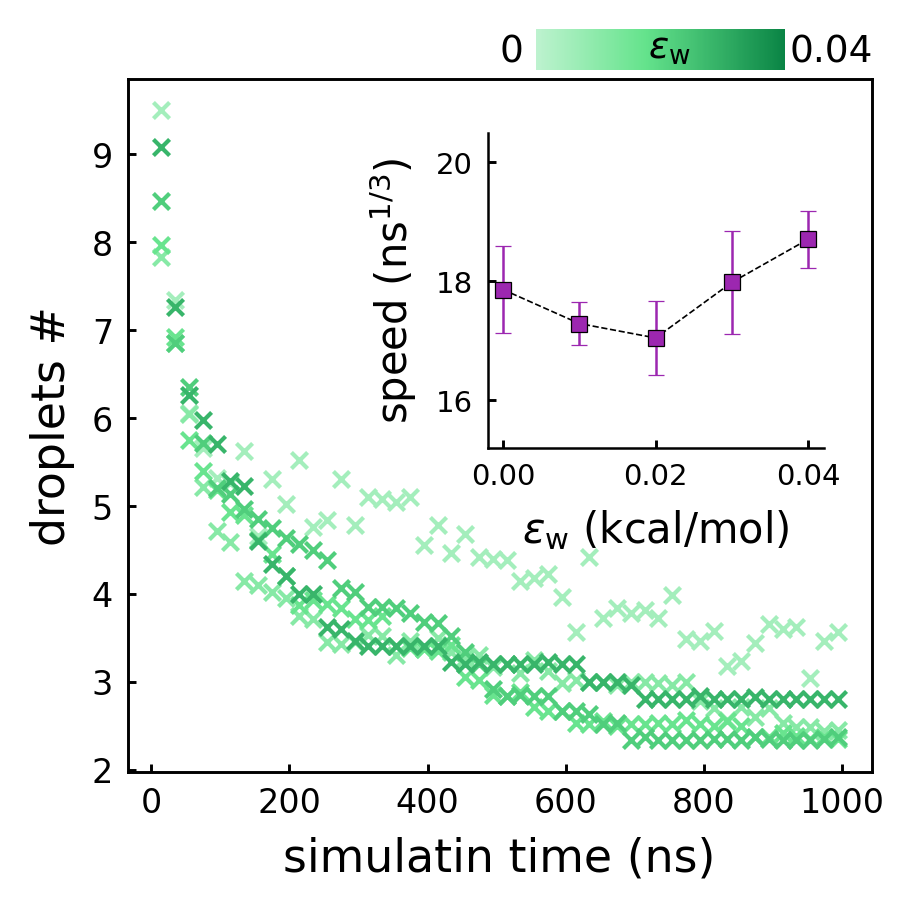

In [ ]:
import sys, os, numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
from scipy.ndimage import label
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
from scipy import ndimage

def count_nucleus(rhoz):
    threshold = np.mean(rhoz) - np.std(rhoz)*0
    mask = rhoz > threshold
    labeled, n_cores = label(mask)

    if labeled[0] != 0 and labeled[-1] != 0:
        n_cores -= 1
    
    return n_cores

# def count_nucleus(density):
#     binary = density > 0
#     labeled, num_features = ndimage.label(binary)

#     if binary[0] and binary[-1] and labeled[0] != labeled[-1]:
#         labeled[labeled == labeled[-1]] = labeled[0]
#         num_features -= 1
    
#     return sum(np.sum(labeled == i) >= 5 for i in range(1, num_features + 1))

def num2time(t, N_inf, A):
    return N_inf + A*(t)**(-1/3)

def plot_rho_after_1ns():
    ew_list = [0.00, 0.01, 0.02, 0.03, 0.04]
    clist = cm.Greens(np.arange(0.35, 0.95, 0.59/(1+len(ew_list))))
    cmap_green = LinearSegmentedColormap.from_list("bright_green", ["#E4F9EC", "#64E38C", "#007A3D"], N=256)
    clist_green = cmap_green(np.linspace(0.25, 0.95, len(clist)))
    # fig = plt.figure(figsize=(4, 3.5), dpi=100)
    fig, ax = plt.subplots(1, 1, figsize=[3.2, 3.0], facecolor='w', dpi=300)
    fit_list, err_list = [], []
    for ew in ew_list:
        folder = 'des_0.20_0.12_{:.2f}'.format(ew)
        num_list_all = []
        for irep in range(6):
            rhoz_path = 'traj_fusion/poly50/{}/rho_data_{}.npy'.format(folder, irep)
            rhoz_all = np.load(rhoz_path)
            time_list, num_list = [], []
            for frame in range(1000, rhoz_all.shape[0]):
                rhoz = rhoz_all[frame]
                time_list.append(10+(frame-1000))
                num_list.append(count_nucleus(rhoz))
            num_list_all.append(num_list)
        
        time_list = np.array(time_list)
        num_avg = np.mean(num_list_all, axis=0)

        smooth_window = 10
        n_windows = len(num_avg) // smooth_window
        avg_density = np.zeros(n_windows)
        var_density = np.zeros(n_windows)
        time_window = np.zeros(n_windows)
        for i in range(n_windows):
            start = i * smooth_window
            end = start + smooth_window
            window_data = num_avg[start:end]
            avg_density[i] = np.mean(window_data)
            var_density[i] = np.var(window_data)
            time_window[i] = np.mean(time_list[start:end])
        
        upper_bounds = [np.inf, np.inf]
        lower_bounds = [1, -np.inf]
        param, pcov = curve_fit(num2time, time_window, avg_density, bounds=(lower_bounds, upper_bounds))
        perr = np.sqrt(np.diag(pcov))
        num_fit = num2time(time_list, *param)

        print('N_inf = {:.1f}, A = {:.2f} ± {:.2f}'.format(param[0], param[1], perr[1]))
        fit_list.append(param[1])
        err_list.append(perr[1])
        
        plt.scatter(time_window[::2], avg_density[::2], marker='x', s=15, linewidths=1, color=clist_green[ew_list.index(ew)])
    
    plt.xlabel('simulatin time (ns)', fontsize=11)
    plt.ylabel('droplets #', fontsize=11)
    plt.tick_params(labelsize=8, direction='in', length=2, width=0.7)

    for spine in ax.spines.values():
        spine.set_linewidth(0.7)

    ax_inset = fig.add_axes([0.5, 0.47, 0.35, 0.35])
    ax_inset.errorbar(ew_list, fit_list, err_list, fmt='s', markerfacecolor='#9C27B0', markeredgecolor='k', markersize=4, markeredgewidth=0.3, linestyle='--', linewidth=0.4, color='k', ecolor='#9C27B0', capsize=2, elinewidth=0.6, capthick=0.6, zorder=1000)
    ax_inset.set_xlabel(r'$\epsilon_{\mathregular{w}}$ (kcal/mol)', fontsize=10)
    ax_inset.set_ylabel(r'speed (ns$^{1/3}$)', fontsize=10)
    ax_inset.set_xticks(ew_list[::2])
    ax_inset.tick_params(labelsize=7, direction='in', length=2, width=0.7)
    ax_inset.spines['top'].set_visible(False)
    ax_inset.spines['right'].set_visible(False)
    ax_inset.spines['left'].set_linewidth(0.6)
    ax_inset.spines['bottom'].set_linewidth(0.6)
    ax_inset.set_ylim(15.2, 20.5)

    cbar_ax = fig.add_axes([0.55, 0.89, 0.26, 0.045])
    cmap_partial = mpl.colors.ListedColormap(cmap_green(np.linspace(0.15, 0.95, 256)))
    norm = Normalize(vmin=-1, vmax=1)
    sm = mpl.cm.ScalarMappable(cmap=cmap_partial, norm=norm)
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.outline.set_linewidth(0)
    cbar.set_ticks([])
    plt.text(0.7, 1.03, r'$\epsilon_\mathregular{w}$', transform=ax.transAxes, fontsize=9, zorder=10)
    plt.text(0.50, 1.025, '0', transform=ax.transAxes, fontsize=9, zorder=10)
    plt.text(0.89, 1.025, '0.04', transform=ax.transAxes, fontsize=9, zorder=10)
    
    plt.savefig("../../figures/diffusion/nuclei2time_ew.svg", format="svg", bbox_inches='tight')
    plt.show()

plot_rho_after_1ns()